# Fraudulent Provider Dataset Construction (PART 2)
## STEP 1
* Process DOJ Press Release Text to Extract Relevant Data Elements

## STEP 2
* Perform NPPES NPI Lookup (via API) for All Potential Provider Names

In [1]:
# Import Pyhon libraries
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import re
import requests
import json
from easydict import EasyDict as edict

nlp = spacy.load("en_core_web_sm")   # prepare for NLP with SpaCy

In [2]:
# Load State Abbreviations 
df_state_abbrev = pd.read_csv('state_abbrev.csv')
df_state_abbrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      52 non-null     object 
 1   latitude   52 non-null     float64
 2   longitude  52 non-null     float64
 3   name       52 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


In [3]:
df_state_abbrev.sample(5)

,state,latitude,longitude,name
46,VA,37.431573,-78.656894,Virginia
3,AZ,34.048928,-111.093731,Arizona
21,ME,45.253783,-69.445469,Maine
1,AL,32.318231,-86.902298,Alabama
31,NJ,40.058324,-74.405661,New Jersey


In [4]:
# Load DOJ Press Releases scraped from website
df_press_releases = pd.read_csv('DOJ_Press_Releases.csv')
df_press_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   release_date    132 non-null    object
 1   release_agency  132 non-null    object
 2   release_title   132 non-null    object
 3   release_url     132 non-null    object
 4   release_text    120 non-null    object
dtypes: object(5)
memory usage: 5.3+ KB


In [5]:
# Display Press Releases which were empty when scraped
df_error_rows = pd.DataFrame()
df_error_rows = df_press_releases[(df_press_releases['release_text'].isna() == True)].copy()
df_error_rows

,release_date,release_agency,release_title,release_url,release_text
75,2017-07-21T00:00:00-04:00,Office of Public Affairs,Barrio Azteca Gang Lieutenant Sentenced to Lif...,https://www.justice.gov/opa/pr/barrio-azteca-g...,NaN
78,2017-08-17T00:00:00-04:00,Office of Public Affairs,Justice Department Announces Actions to Streng...,https://www.justice.gov/opa/pr/justice-departm...,NaN
82,2017-09-20T00:00:00-04:00,Office of Public Affairs,Miami Physician Sentenced to 97 Months for Rol...,https://www.justice.gov/opa/pr/miami-physician...,NaN
84,2017-10-23T00:00:00-04:00,Office of Public Affairs,"30 Members and Associates of The ""Nine Trey Ga...",https://www.justice.gov/opa/pr/30-members-and-...,NaN
89,2017-10-25T00:00:00-04:00,Office of Public Affairs,Opening Statement by U.S. Attorney R. Trent Sh...,https://www.justice.gov/opa/pr/opening-stateme...,NaN
90,2017-10-26T00:00:00-04:00,Office of Public Affairs,Pittsburgh-Area Doctor Charged With Unlawfully...,https://www.justice.gov/opa/pr/pittsburgh-area...,NaN
91,2017-10-26T00:00:00-04:00,Office of Public Affairs,Founder and Owner of Pharmaceutical Company In...,https://www.justice.gov/opa/pr/founder-and-own...,NaN
93,2017-10-27T00:00:00-04:00,Office of Public Affairs,DEA Joins Local Law Enforcement Partners in Na...,https://www.justice.gov/opa/pr/dea-joins-local...,NaN
97,2017-11-13T00:00:00-05:00,Office of Public Affairs,Attorney General Jeff Sessions Appoints Member...,https://www.justice.gov/opa/pr/attorney-genera...,NaN
98,2017-11-07T00:00:00-05:00,Office of Public Affairs,Drug Enforcement Administration Collects Recor...,https://www.justice.gov/opa/pr/drug-enforcemen...,NaN


In [6]:
# Remove rows where Press Release text was no properly scraped from website
df_press_releases.dropna(subset=['release_text'], inplace=True)
df_press_releases

,release_date,release_agency,release_title,release_url,release_text
0,2020-03-10T00:00:00-04:00,Office of Public Affairs,Owner of Detroit-Area Health Care Clinic Sente...,https://www.justice.gov/opa/pr/owner-detroit-a...,The owner of a Detroit-area physical therapy c...
1,2019-10-29T00:00:00-04:00,Office of Public Affairs,Tennessee Medical Doctor and Advanced Practice...,https://www.justice.gov/opa/pr/tennessee-medic...,A Tennessee medical doctor and an advanced pra...
2,2019-11-13T00:00:00-05:00,Office of Public Affairs,Owner of Detroit-Area Health Care Clinics Plea...,https://www.justice.gov/opa/pr/owner-detroit-a...,"The owner of a Detroit, Michigan-area physical..."
3,2019-11-22T00:00:00-05:00,Office of Public Affairs,New Jersey/Pennsylvania Doctor Pleads Guilty t...,https://www.justice.gov/opa/pr/new-jerseypenns...,A doctor who practiced in New Jersey and Penns...
4,2019-09-24T00:00:00-04:00,Office of Public Affairs,Second Appalachian Region Prescription Opioid ...,https://www.justice.gov/opa/pr/second-appalach...,The Justice Department announced today the sec...
...,...,...,...,...,...
127,2015-07-28T00:00:00-04:00,Office of Public Affairs,Colombian National Charged in North Dakota wit...,https://www.justice.gov/opa/pr/colombian-natio...,Acting U.S. Attorney Christopher C. Myers for ...
128,2015-01-07T00:00:00-05:00,Office of Public Affairs,FBI Arrests Defendants Charged with Traffickin...,https://www.justice.gov/opa/pr/fbi-arrests-def...,FBI agents today arrested five of six Jefferso...
129,2015-09-04T00:00:00-04:00,Office of Public Affairs,Versailles Man Indicted for Illegal Distributi...,https://www.justice.gov/opa/pr/versailles-man-...,A federal grand jury returned an indictment ch...
130,2015-09-28T00:00:00-04:00,Office of Public Affairs,U.S. Department of Justice's Office of Communi...,https://www.justice.gov/opa/pr/us-department-j...,Deputy Attorney General Sally Quillian Yates t...


In [7]:
df_press_releases.sample(5)

,release_date,release_agency,release_title,release_url,release_text
103,2016-09-24T00:00:00-04:00,Office of Public Affairs,Department of Justice Releases Strategy Memo t...,https://www.justice.gov/opa/pr/department-just...,"As part of the Obama Administration’s , to add..."
19,2020-02-04T00:00:00-05:00,Office of Public Affairs,Four Detroit-Area Physicians Found Guilty of H...,https://www.justice.gov/opa/pr/four-detroit-ar...,A federal jury found four Detroit-area physici...
9,2019-09-26T00:00:00-04:00,Office of Public Affairs,Federal Health Care Fraud Takedown in Northeas...,https://www.justice.gov/opa/pr/federal-health-...,The Justice Department today announced a coord...
74,2018-05-04T00:00:00-04:00,Office of Public Affairs,DEA Suspends the Registration of Morris & Dick...,https://www.justice.gov/opa/pr/dea-suspends-re...,The Drug Enforcement Administration today anno...
22,2020-02-21T00:00:00-05:00,Office of Public Affairs,West Tennessee Psychiatrist Found Guilty of Un...,https://www.justice.gov/opa/pr/west-tennessee-...,A federal jury found a west Tennessee doctor g...


In [8]:
# Create dataframe to contain monthly counts by year
df_pr_count = df_press_releases[[
    'release_date',
    'release_title'
]]

df_pr_count.sample(5)

,release_date,release_title
121,2017-07-11T00:00:00-04:00,Twelve Alleged Baltimore TTG Members and Assoc...
50,2018-08-15T00:00:00-04:00,Attorney General’s Advisory Subcommittee on Na...
72,2018-06-06T00:00:00-04:00,Health Care CEO and Four Physicians Charged in...
102,2016-09-23T00:00:00-04:00,Office of Justice Programs Announces Grant Awa...
17,2020-01-31T00:00:00-05:00,Alabama Physician Pleads Guilty to Drug Distri...


In [9]:
# Add column for Month-Year, ignoring time 
df_pr_count['month_year'] = pd.to_datetime(df_pr_count['release_date'], utc=True).dt.to_period('M')
df_pr_count

C:\Users\theru\Anaconda3\envs\orange3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
C:\Users\theru\Anaconda3\envs\orange3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,release_date,release_title,month_year
0,2020-03-10T00:00:00-04:00,Owner of Detroit-Area Health Care Clinic Sente...,2020-03
1,2019-10-29T00:00:00-04:00,Tennessee Medical Doctor and Advanced Practice...,2019-10
2,2019-11-13T00:00:00-05:00,Owner of Detroit-Area Health Care Clinics Plea...,2019-11
3,2019-11-22T00:00:00-05:00,New Jersey/Pennsylvania Doctor Pleads Guilty t...,2019-11
4,2019-09-24T00:00:00-04:00,Second Appalachian Region Prescription Opioid ...,2019-09
...,...,...,...
127,2015-07-28T00:00:00-04:00,Colombian National Charged in North Dakota wit...,2015-07
128,2015-01-07T00:00:00-05:00,FBI Arrests Defendants Charged with Traffickin...,2015-01
129,2015-09-04T00:00:00-04:00,Versailles Man Indicted for Illegal Distributi...,2015-09
130,2015-09-28T00:00:00-04:00,U.S. Department of Justice's Office of Communi...,2015-09


In [10]:
# Determine Month_Year Counts and sort data
df_pr_count = df_pr_count[[
    'month_year',
    'release_title'
]].groupby(['month_year']).count().reset_index()

df_pr_count.sort_values(['month_year'], ascending=False, inplace=True)

df_pr_count

,month_year,release_title
45,2020-03,2
44,2020-02,6
43,2020-01,3
42,2019-12,4
41,2019-11,3
40,2019-10,4
39,2019-09,6
38,2019-08,2
37,2019-07,3
36,2019-06,2


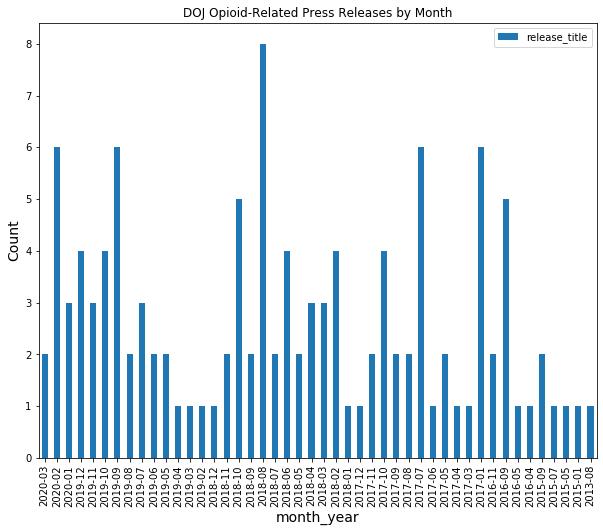

In [11]:
# Chart Opioid Press Releases Found
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('DOJ Opioid-Related Press Releases by Month')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
df_pr_count.plot.bar(x ='month_year', ax=ax)

## DATA MINING
* Extract entities and locations for each press release
* Perform NPPES Registry lookup via API call
* Potential Improvement: Look at PhraseMatcher functionality in spaCy to improve NLP results

In [12]:
df_press_releases.sort_values(['release_date'], ascending=False, inplace=True)
df_press_releases

,release_date,release_agency,release_title,release_url,release_text
0,2020-03-10T00:00:00-04:00,Office of Public Affairs,Owner of Detroit-Area Health Care Clinic Sente...,https://www.justice.gov/opa/pr/owner-detroit-a...,The owner of a Detroit-area physical therapy c...
23,2020-03-10T00:00:00-04:00,Office of Public Affairs,"The National Comprehensive Opioid, Stimulant, ...",https://www.justice.gov/opa/pr/national-compre...,"The 2020 National Comprehensive Opioid, Stimul..."
24,2020-02-26T00:00:00-05:00,Office of Public Affairs,Tennessee Podiatrist Pleads Guilty to Unlawful...,https://www.justice.gov/opa/pr/tennessee-podia...,A Tennessee podiatrist pleaded guilty today fo...
22,2020-02-21T00:00:00-05:00,Office of Public Affairs,West Tennessee Psychiatrist Found Guilty of Un...,https://www.justice.gov/opa/pr/west-tennessee-...,A federal jury found a west Tennessee doctor g...
21,2020-02-21T00:00:00-05:00,Office of Public Affairs,Ohio Doctor Pleads Guilty to Unlawful Distribu...,https://www.justice.gov/opa/pr/ohio-doctor-ple...,An Ohio physician who owned a Dayton-area medi...
...,...,...,...,...,...
129,2015-09-04T00:00:00-04:00,Office of Public Affairs,Versailles Man Indicted for Illegal Distributi...,https://www.justice.gov/opa/pr/versailles-man-...,A federal grand jury returned an indictment ch...
127,2015-07-28T00:00:00-04:00,Office of Public Affairs,Colombian National Charged in North Dakota wit...,https://www.justice.gov/opa/pr/colombian-natio...,Acting U.S. Attorney Christopher C. Myers for ...
124,2015-05-14T00:00:00-04:00,Office of Public Affairs,Long-Term Care Pharmacy to Pay $31.5 Million t...,https://www.justice.gov/opa/pr/long-term-care-...,PharMerica Corporation has agreed to pay the U...
128,2015-01-07T00:00:00-05:00,Office of Public Affairs,FBI Arrests Defendants Charged with Traffickin...,https://www.justice.gov/opa/pr/fbi-arrests-def...,FBI agents today arrested five of six Jefferso...


### Define Functions

In [13]:
# FUNCTION: Extacted entities from cleaned text
def extract_entities(cleaned_text):
    
    # Process cleaned text using spaCy NLP and extract entities labeled as organizations, people, states, cities, countries, and other locations
    df_extracted_entities = pd.DataFrame()

    doc = nlp(cleaned_text)   # run NLP on cleaned text

    # Create empty dataframe for NLP results
    df_extracted_entities = pd.DataFrame(
        columns=[
            'text',
            'start_pos',
            'end_pos',
            'entity_type'
        ]
    )

    # Set list of key entity types to extract
    entity_type_filter = {
        'ORG',          # Companies, agencies, institutions, etc.
        'PERSON',       # People
        'GPE',          # Countries, cities, states
        'LOC'          # Non-GPE locations

    }

    # Parse through NLP entity objects in text and populate dataframe
    for ent in doc.ents:
    
        if (ent.label_ in entity_type_filter):
    
            df_extracted_entities = df_extracted_entities.append(
                {
                    'text': ent.text,
                    'start_pos': ent.start_char,
                    'end_pos': ent.end_char,
                    'entity_type': ent.label_
                }, 
                ignore_index=True
        )
        
    # Parse through NLP part of speech objects in text and populate dataframe with identified verbs
    for token in doc:
        if (token.pos_ == "VERB"):
            
            df_extracted_entities = df_extracted_entities.append(
                {
                    'text': token.text,
                    'entity_type': token.pos_,
                }, 
                ignore_index=True
            )
    
    return df_extracted_entities


In [14]:
# FUNCTION: Parse name into parts in preparation for NPPES API call
def prepare_name_param(df_people):
    
    # Split names into parts
    df_full_name = pd.DataFrame()
    df_full_name = df_people['text'].str.split(" ", n = 4, expand = True)
    #print(df_full_name)
    
    # Rename name-part columns
    for i in range(0, len(df_full_name.columns)):
        col_name = 'name_' + str(i)
        df_full_name = df_full_name.rename(columns={i: col_name})   
    
    #df_full_name
    
    # Determine name-part count for each person
    df_name_part = pd.DataFrame()
    for row in df_full_name.itertuples():
        name_count = 0
    
        for i in range(0, len(df_full_name.columns)):
            if row[i+1] != None:
                name_count += 1
        
        df_name_part = df_name_part.append({'part_count': name_count}, ignore_index=True)

    #df_name_part

    # Combine all name data into single dataframe
    df_combined = pd.DataFrame()
    df_combined = pd.concat([df_people, df_full_name, df_name_part], axis=1)
    #df_combined
    
    # Iterate through people to get first / last name
    df_api_param = pd.DataFrame()
    for row in df_combined.itertuples():
        if row.part_count == 2:
            first_name = row.name_0
            last_name = row.name_1
            make_call = True
        elif row.part_count == 3 or row.part_count == 4:
            first_name = row.name_0
            last_name = row.name_2
            make_call = True
        else:
            make_call = False
        
        if make_call == True:
            df_api_param = df_api_param.append({'first_name': first_name, 'last_name': last_name}, ignore_index=True)
            #print(first_name + '|' + last_name)
    
    print('Number of Identified People: ' + str(len(df_api_param)))
    
    return df_api_param


In [15]:
# FUNCTION: Prepare location for NPPES API call
def prepare_location_param(df_entities):
    # Create dataframe for locations
    df_location = pd.DataFrame()
    df_location = df_entities.loc[df_entities['entity_type'].isin(['GPE', 'LOC'])].reset_index()
    #df_location
    
    if len(df_location) != 0:
    
        # Determine state code for each location
        df_state_code = pd.DataFrame()
        for row in df_location.itertuples():
            state_code = state_code_lookup(row.text)
            df_state_code = df_state_code.append({'state_code': state_code}, ignore_index=True)

    else:
        df_state_code = pd.DataFrame()
        df_state_code = df_state_code.append({'state_code': 'XX'}, ignore_index=True)
        #df_state_code
    
    df_filtered_state = pd.DataFrame()
    df_filtered_state = df_state_code[(df_state_code.state_code != 'XX')].copy()
    df_filtered_state = df_filtered_state.drop_duplicates()
    
    print('Number of Identified, Unique States: ' + str(len(df_filtered_state)))
    
    return df_filtered_state
    

In [16]:
# FUNCTION: Determine state code needed for NPPES API call and return 2 letter code
def state_code_lookup(state_name):
    try:
        state_code = df_state_abbrev.loc[df_state_abbrev['name'] == state_name, 'state'].iloc[0]
    except:
        state_code = 'XX'
     
    return state_code

In [17]:
# FUNCTION: Construct NPPES API call and return string
#     NOTE: All paramaters included (commented out) but only First Name, Last Name, and State used
def construct_nppes_api_call(first_name, last_name, state_code):
    nppes_api = ('https://npiregistry.cms.hhs.gov/api/?'
        #+ 'number='  
        #+ '&enumeration_type='  
        #+ '&taxonomy_description='  
        + '&first_name=' + first_name  
        + '&last_name=' + last_name  
        #+ '&organization_name='  
        #+ '&address_purpose='  
        #+ '&city='   
        + '&state=' + state_code  
        #+ '&postal_code='  
        #+ '&country_code='  
        #+ '&limit='  
        #+ '&skip='  
        #+ '&pretty=on'  
        + '&version=2.1'
    )
    
    return nppes_api

In [18]:
# FUNCTION: Perform NPPES API call and return results as EasyDict object
def call_nppes_api(first_name, last_name, state):
    #state_code = state_code_lookup(state_name)
    nppes_api = construct_nppes_api_call(first_name, last_name, state)
    #print(nppes_api)
    response = requests.get(nppes_api)

    #print('Status Code: ' + str(response.status_code))
    
    #df_api_results = json.loads(response.text)
    api_results = edict(json.loads(response.text))
    
    #print('Length of Dict Result: ' + str(len(api_results)))
    
    return api_results

### Process Press Releases 

In [19]:
# Create dataframe of press release text
df_mining = df_press_releases[['release_title', 'release_text', 'release_date', 'release_url']].copy()
df_mining

,release_title,release_text,release_date,release_url
0,Owner of Detroit-Area Health Care Clinic Sente...,The owner of a Detroit-area physical therapy c...,2020-03-10T00:00:00-04:00,https://www.justice.gov/opa/pr/owner-detroit-a...
23,"The National Comprehensive Opioid, Stimulant, ...","The 2020 National Comprehensive Opioid, Stimul...",2020-03-10T00:00:00-04:00,https://www.justice.gov/opa/pr/national-compre...
24,Tennessee Podiatrist Pleads Guilty to Unlawful...,A Tennessee podiatrist pleaded guilty today fo...,2020-02-26T00:00:00-05:00,https://www.justice.gov/opa/pr/tennessee-podia...
22,West Tennessee Psychiatrist Found Guilty of Un...,A federal jury found a west Tennessee doctor g...,2020-02-21T00:00:00-05:00,https://www.justice.gov/opa/pr/west-tennessee-...
21,Ohio Doctor Pleads Guilty to Unlawful Distribu...,An Ohio physician who owned a Dayton-area medi...,2020-02-21T00:00:00-05:00,https://www.justice.gov/opa/pr/ohio-doctor-ple...
...,...,...,...,...
129,Versailles Man Indicted for Illegal Distributi...,A federal grand jury returned an indictment ch...,2015-09-04T00:00:00-04:00,https://www.justice.gov/opa/pr/versailles-man-...
127,Colombian National Charged in North Dakota wit...,Acting U.S. Attorney Christopher C. Myers for ...,2015-07-28T00:00:00-04:00,https://www.justice.gov/opa/pr/colombian-natio...
124,Long-Term Care Pharmacy to Pay $31.5 Million t...,PharMerica Corporation has agreed to pay the U...,2015-05-14T00:00:00-04:00,https://www.justice.gov/opa/pr/long-term-care-...
128,FBI Arrests Defendants Charged with Traffickin...,FBI agents today arrested five of six Jefferso...,2015-01-07T00:00:00-05:00,https://www.justice.gov/opa/pr/fbi-arrests-def...


In [ ]:
for row in df_mining.head(2).itertuples():
    print(row[4])

In [20]:
# STRUCTURE OF LOOP TO PROCESS ALL PRESS RELEASES:
# - clean text
# - extract all entities
# - find people
# ---- determine first and last name
# - find locations
# ---- determine unique states and get associated state code 
# - perform NPPES lookup
# ---- create and execute API call
# ---- retrieve and store results

# Create dataframe to hold NPPES API Results
df_api_results = pd.DataFrame()  

# Create dataframe to hold all extracted entities
df_entity_archive = pd.DataFrame()

for row in df_mining.itertuples():
    print('TITLE: ' + row[1] + ' for row ' + str(row[0]))
    
    # Clean press release text (remove non-ascii chars, new lines, etc.)
    #cleaned_text = df_mining['release_text'][20].encode('ascii', 'ignore').decode()   # remove non-ASCII characters
    cleaned_text = ''
    cleaned_text = row[2].encode('ascii', 'ignore').decode()   # remove non-ASCII characters
    cleaned_text = cleaned_text.replace('\n', '')              # remove new lines
    cleaned_text = cleaned_text.replace('.,', '. ')            # remove ".," which occurs frequently 
    #print (cleaned_text)

    # Create dataframe to hold extracted entities
    df_entities = pd.DataFrame()
    df_entities = extract_entities(cleaned_text)   # call function to extract entities from cleaned text
    
    # Create temporary archive dataframe to hold extracted entities
    df_entity_archive_temp = pd.DataFrame()
    df_entity_archive_temp = df_entities.copy()
    
    # Add release_date and release_url to entity temp archive
    release_date = row[3]
    release_url = row[4]
    df_entity_archive_temp['release_date'] = release_date
    df_entity_archive_temp['release_url'] = release_url
    
    # Append entities to main entity archive for use in NPI Resolution 
    df_entity_archive = df_entity_archive.append(df_entity_archive_temp) 
    
    # Create dataframe of identified people
    df_people = pd.DataFrame()
    df_people = df_entities.loc[df_entities['entity_type'] == 'PERSON'].reset_index()
    #df_people
    
    # Create dataframe for name parameters
    df_name_params = pd.DataFrame()
    df_name_params = prepare_name_param(df_people)
    
    # Create dataframe for location parameters
    df_location_params = pd.DataFrame()
    df_location_params = prepare_location_param(df_entities)

    # Prevent processing rows with missing API parameters
    if len(df_name_params) == 0 or len(df_location_params) == 0:
        process = False
    else:
        process = True

    # Process valid rows    
    if process == True: 
        for state in df_location_params['state_code']:
            for row in df_name_params.itertuples():
                df_api_results_temp = pd.DataFrame()
                
                #nppes_api = construct_nppes_api_call(row.first_name, row.last_name, state)
                api_results = call_nppes_api(row.first_name, row.last_name, state)
                df_api_results_temp = df_api_results_temp.append(pd.DataFrame.from_dict(api_results), ignore_index=True)
    
                # Add release_date and release_url to each row of api results
                df_api_results_temp['release_date'] = release_date
                df_api_results_temp['release_url'] = release_url
                
                df_api_results = df_api_results.append(df_api_results_temp)
    

TITLE: Owner of Detroit-Area Health Care Clinic Sentenced to Prison for a Drug Diversion Scheme for row 0
Number of Identified People: 9
Number of Identified, Unique States: 1
TITLE: The National Comprehensive Opioid, Stimulant, and Substance Abuse Program Forum Presents Ways to Combat Addiction Crisis for row 23
Number of Identified People: 3
Number of Identified, Unique States: 1
TITLE: Tennessee Podiatrist Pleads Guilty to Unlawfully Distributing Controlled Substances for row 24
Number of Identified People: 9
Number of Identified, Unique States: 1
TITLE: West Tennessee Psychiatrist Found Guilty of Unlawfully Distributing Opioids for row 22
Number of Identified People: 7
Number of Identified, Unique States: 1
TITLE: Ohio Doctor Pleads Guilty to Unlawful Distribution of Opioids  for row 21
Number of Identified People: 16
Number of Identified, Unique States: 3
TITLE: Federal Jury Convicts Four Defendants for Operating Knoxville-Area Pill Mills for row 20
Number of Identified People: 12

In [21]:
df_api_results.sample(5)

,result_count,results,release_date,release_url
0,3,"{'enumeration_type': 'NPI-1', 'number': 146765...",2019-07-12T00:00:00-04:00,https://www.justice.gov/opa/pr/colombian-natio...
0,1,"{'enumeration_type': 'NPI-1', 'number': 157858...",2018-08-01T00:00:00-04:00,https://www.justice.gov/opa/pr/michigan-physic...
2,10,"{'enumeration_type': 'NPI-1', 'number': 171097...",2019-08-28T00:00:00-04:00,https://www.justice.gov/opa/pr/charges-filed-a...
6,9,"{'enumeration_type': 'NPI-1', 'number': 119497...",2018-10-25T00:00:00-04:00,https://www.justice.gov/opa/pr/justice-departm...
6,10,"{'enumeration_type': 'NPI-1', 'number': 135656...",2018-10-25T00:00:00-04:00,https://www.justice.gov/opa/pr/justice-departm...


In [22]:
df_api_results.shape

(860, 4)

In [23]:
df_entity_archive.sample(5)

,text,start_pos,end_pos,entity_type,release_date,release_url
321,met,NaN,NaN,VERB,2019-04-17T00:00:00-04:00,https://www.justice.gov/opa/pr/appalachian-reg...
2039,presented,NaN,NaN,VERB,2016-11-10T00:00:00-05:00,https://www.justice.gov/opa/pr/attorney-genera...
359,laundered,NaN,NaN,VERB,2018-04-10T00:00:00-04:00,https://www.justice.gov/opa/pr/acting-assistan...
1755,assisted,NaN,NaN,VERB,2016-11-10T00:00:00-05:00,https://www.justice.gov/opa/pr/attorney-genera...
32,is,NaN,NaN,VERB,2019-12-13T00:00:00-05:00,https://www.justice.gov/opa/pr/justice-departm...


In [24]:
df_entity_archive.shape

(21112, 6)

In [25]:
# Output file with results of NPPES Lookups for extracted entities
df_api_results.to_csv('nppes_results.csv', index=False)

In [26]:
# Output file with all extracted entities
df_entity_archive.to_csv('entity_archive.csv', index=False)

## FOR DEBUGGING PURPOSES ONLY
### Manual Processing of Press Release Data Mining for debugging isolated issues

In [ ]:
raw_text = df_mining['release_text'][2]
print (raw_text)

In [ ]:
# Clean press release text (remove non-ascii chars, new lines, etc.)
cleaned_text = raw_text.encode('ascii', 'ignore').decode()   # remove non-ASCII characters
cleaned_text = cleaned_text.replace('\n', '')              # remove new lines
cleaned_text = cleaned_text.replace('.,', '. ')            # remove ".," which occurs frequently 
print (cleaned_text)

In [ ]:
# Process cleaned text using spaCy NLP and extract entities labeled as organizations, people, states, cities, countries, and other locations
df_extracted_entities = pd.DataFrame()

doc = nlp(cleaned_text)   # run NLP on cleaned text

# Create empty dataframe for NLP results
df_extracted_entities = pd.DataFrame(
    columns=[
        'text',
        'start_pos',
        'end_pos',
        'entity_type'
    ]
)

# Set list of key entity types to extract
entity_type_filter = {
    'ORG',          # Companies, agencies, institutions, etc.
    'PERSON',       # People
    'GPE',          # Countries, cities, states
    'LOC'           # Non-GPE locations
}

# Parse through NLP results and populate dataframe
for ent in doc.ents:
    
    if (ent.label_ in entity_type_filter):
    
        df_extracted_entities = df_extracted_entities.append(
            {
                'text': ent.text,
                'start_pos': ent.start_char,
                'end_pos': ent.end_char,
                'entity_type': ent.label_
            }, 
            ignore_index=True
    )

for token in doc:
    if (token.pos_ == "VERB"):
        print(token.text, token.pos_, token.lemma_)        
        
df_extracted_entities.info()

In [ ]:
df_extracted_entities

In [ ]:
df_entity_archive_temp = pd.DataFrame()
df_entity_archive_temp = df_extracted_entities.copy()
df_entity_archive_temp


In [ ]:
df_entity_archive_temp['release_date'] = df_mining['release_date'][1]
df_entity_archive_temp['release_url'] = df_mining['release_url'][1]
df_entity_archive_temp

In [ ]:
df_entity_archive = pd.DataFrame()
df_entity_archive = df_entity_archive.append(df_entity_archive_temp)   
df_entity_archive

In [ ]:
df_entity_archive.to_csv('entity_archive.csv', index=False)

In [ ]:
df_extracted_entities.loc[df_extracted_entities['entity_type'] == 'GPE']

In [ ]:
# Create dataframe of identified people
df_people = pd.DataFrame()
df_people = df_extracted_entities.loc[df_extracted_entities['entity_type'] == 'PERSON'].reset_index()
df_people

In [ ]:
# Split names into parts
df_full_name = pd.DataFrame()
df_full_name = df_people['text'].str.split(" ", n = 4, expand = True)
print(df_full_name)

In [ ]:
# Rename name-part columns
for i in range(0, len(df_full_name.columns)):
    col_name = 'name_' + str(i)
    df_full_name = df_full_name.rename(columns={i: col_name})   
    
df_full_name

In [ ]:
# Determine name-part count for each person
df_name_part = pd.DataFrame()
for row in df_full_name.itertuples():
    name_count = 0
    
    for i in range(0, len(df_full_name.columns)):
        if row[i+1] != None:
            name_count += 1
    
    df_name_part = df_name_part.append({'part_count': name_count}, ignore_index=True)

df_name_part

In [ ]:
# Combine all name data into single dataframe
df_combined = pd.DataFrame()
df_combined = pd.concat([df_people, df_full_name, df_name_part], axis=1)
df_combined

In [ ]:
# Iterate through people to get first / last name
df_api_param = pd.DataFrame()
for row in df_combined.itertuples():
    if row.part_count == 2:
        first_name = row.name_0
        last_name = row.name_1
        make_call = True
    elif row.part_count == 3 or row.part_count == 4:
        first_name = row.name_0
        last_name = row.name_2
        make_call = True
    else:
        make_call = False
        
    if make_call == True:
        df_api_param = df_api_param.append({'first_name': first_name, 'last_name': last_name}, ignore_index=True)
        #print(first_name + '|' + last_name)
        
df_api_param        

In [ ]:
len(df_api_param)

In [ ]:
# Create dataframe for locations
df_location = pd.DataFrame()
df_location = df_extracted_entities.loc[df_extracted_entities['entity_type'].isin(['GPE', 'LOC'])].reset_index()
df_location

In [ ]:
# Determine state code for each location
df_state_code = pd.DataFrame()
for row in df_location.itertuples():
    state_code = state_code_lookup(row.text)
    df_state_code = df_state_code.append({'state_code': state_code}, ignore_index=True)

df_state_code

In [ ]:
df_filtered_state = pd.DataFrame()
df_filtered_state = df_state_code[(df_state_code.state_code != 'XX')].copy()
df_filtered_state = df_filtered_state.drop_duplicates()
df_filtered_state

In [ ]:
len(df_filtered_state)

In [ ]:
# Create API call, execute, and store results
df_api_results = pd.DataFrame()

if len(df_api_param) == 0 or len(df_filtered_state) == 0:
    process = False
else:
    process = True

print(process)
    
if process == True:    
    for state in df_filtered_state['state_code']:
        for row in df_api_param.itertuples():
            #nppes_api = construct_nppes_api_call(row.first_name, row.last_name, state)
            api_results = call_nppes_api(row.first_name, row.last_name, state)
                
            df_api_results = df_api_results.append(pd.DataFrame.from_dict(api_results), ignore_index=True)


In [ ]:
# Hard-coded test of api call and response
nppes_api = 'https://npiregistry.cms.hhs.gov/api/?number=&enumeration_type=&taxonomy_description=&first_name=Darrel&last_name=Rinehart&organization_name=&address_purpose=&city=&state=MD&postal_code=&country_code=&limit=&skip=&pretty=on&version=2.1'
response = requests.get(nppes_api)
print(response.json())